# **Deep Learning Project**

## **Phase 0**



*   Sobhan Asasi    
(400206392)
*   Mohammad Hajipour   
(401301843)
*   Amin Robatian   
(400301075)




In [1]:
#!pip install face_recognition

# Requirements

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from torchvision.transforms import ToTensor

import face_recognition
import pickle
import cv2
import os

from PIL import Image
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import random
import time
import ast

import itertools
import re
import os
import contextlib
from typing import Any, Callable, Dict, IO, Iterable, Iterator, List, Optional, Tuple, TypeVar
import requests
from torch.utils.model_zoo import tqdm
import zipfile

In [3]:
def seed_everything(seed: int):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = True

seed_everything(42)

# Download Dataset Functions

In [4]:
def create_dataset_directory(root, dataset_name):
        
        filename_dict = {'train':'train.zip',
                         'dev':'dev.zip',
                         'test':'test.zip',
                         'MSCTD_data_train':'MSCTD_data_train.zip',
                         'MSCTD_data_dev':'MSCTD_data_dev.zip',
                         'MSCTD_data_test':'MSCTD_data_test.zip'}
        
        id_dict = {'train':'156yOz7M1sAfz4RK6OEQoPsaaPOMhrsT6',
                   'dev':'1URhTfBeUQiAmzb_2gxtn4MCXUxFywGnR',
                   'test':'1MbzM9Twe5KCWAKwZYvZO_OK-v8qRVSPF',
                   'MSCTD_data_train':'1AEwXhfMApCWzGyGr6KRzPtx7hBy3jZXt',
                   'MSCTD_data_dev': '1h3YnPZlIdSqPsggoms1zK2ZF5enSBcDH',
                   'MSCTD_data_test':'1pYWqfTd9rZuQuKgL0wv34Ybz5OINI6SV'}
        
        isExist = os.path.exists(os.path.join(root, dataset_name))
        
        if not isExist:
            # Create a new directory because it does not exist
            os.makedirs(os.path.join(root, dataset_name))
            print("The " +dataset_name+ " directory is created!")
            print('Downloading ...')
            download_file_from_google_drive(id_dict['MSCTD_data_'+dataset_name],
                                            os.path.join(root, dataset_name, filename_dict['MSCTD_data_'+dataset_name]))
            download_file_from_google_drive(id_dict[dataset_name],
                                os.path.join(root, dataset_name, filename_dict[dataset_name]))
            
            _extract_zip(os.path.join(root, dataset_name, filename_dict['MSCTD_data_'+dataset_name]),os.path.join(root, dataset_name))
            _extract_zip(os.path.join(root, dataset_name, filename_dict[dataset_name]),os.path.join(root, dataset_name))
            
        if(dataset_name=='train'):
            list_path_out = [os.path.join(root, dataset_name, filename_dict['MSCTD_data_'+dataset_name].split('.')[0], 'english_'+dataset_name+'.txt'),
           os.path.join(root, dataset_name, filename_dict['MSCTD_data_'+dataset_name].split('.')[0], 'sentiment_'+dataset_name+'.txt'),
           os.path.join(root, dataset_name, filename_dict['MSCTD_data_'+dataset_name].split('.')[0], 'image_index_'+dataset_name+'.txt'),
           os.path.join(root, dataset_name, filename_dict[dataset_name].split('.')[0]+'_ende')]
        else:
            list_path_out = [os.path.join(root, dataset_name, filename_dict['MSCTD_data_'+dataset_name].split('.')[0], 'english_'+dataset_name+'.txt'),
           os.path.join(root, dataset_name, filename_dict['MSCTD_data_'+dataset_name].split('.')[0], 'sentiment_'+dataset_name+'.txt'),
           os.path.join(root, dataset_name, filename_dict['MSCTD_data_'+dataset_name].split('.')[0], 'image_index_'+dataset_name+'.txt'),
           os.path.join(root, dataset_name, filename_dict[dataset_name].split('.')[0])]
        
        return list_path_out
    
    
    
    
            
def files_to_dataframe(text_add, sentiment_add, index_add):
    """
    This function convert all necessary .txt files to a single dataframe

    Args :
    text_add : .txt of chats.
    sentiment_add : .txt of emotions for each line.
    index_add : .txt of related images for each line.

    Output -> pd.dataframe

    """
    df_text = pd.read_csv(text_add, delimiter = "\r\t", header=None, engine='python')
    df_text.columns = ['text']

    df_sentiment = pd.read_csv(sentiment_add, delimiter = "\t", header=None)
    df_sentiment.columns = ['label']

    df_index = pd.read_csv(index_add, delimiter = "\t", header=None)
    df_index.columns = ['indexes']

    zero_data = np.zeros(shape=(len(df_sentiment),1),dtype=int)
    df_dialogue = pd.DataFrame(zero_data)
    df_dialogue.columns = ['dialogue']
    counter = 0
    for i in range(len(df_sentiment)):
        if i not in ast.literal_eval(df_index.indexes[counter]):
            counter += 1
        df_dialogue.dialogue[i] = counter
    #concatenation
    lst = [df_text, df_sentiment, df_index, df_dialogue]  # List of your dataframes
    df_result = pd.concat(lst, axis =1)

    return df_result
    #return text, indexes, label



def download_file_from_google_drive(file_id: str, fpath: str):
    """Download a Google Drive file from  and place it in root.
    Args:
        file_id (str): id of file to be downloaded
        root (str): Directory to place downloaded file in
        filename (str, optional): Name to save the file under. If None, use the id of the file.
    """

    url = "https://drive.google.com/uc"
    params = dict(id=file_id, export="download")
    with requests.Session() as session:
        response = session.get(url, params=params, stream=True)

        for key, value in response.cookies.items():
            if key.startswith("download_warning"):
                token = value
                break
        else:
            api_response, content = _extract_gdrive_api_response(response)
            token = "t" if api_response == "Virus scan warning" else None

        if token is not None:
            response = session.get(url, params=dict(params, confirm=token), stream=True)
            api_response, content = _extract_gdrive_api_response(response)

        if api_response == "Quota exceeded":
            raise RuntimeError(
                f"The daily quota of the file {fpath} is exceeded and it "
                f"can't be downloaded. This is a limitation of Google Drive "
                f"and can only be overcome by trying again later."
            )

        _save_response_content(content, fpath)

    # In case we deal with an unhandled GDrive API response, the file should be smaller than 10kB and contain only text
    if os.stat(fpath).st_size < 10 * 1024:
        with contextlib.suppress(UnicodeDecodeError), open(fpath) as fh:
            text = fh.read()
            # Regular expression to detect HTML. Copied from https://stackoverflow.com/a/70585604
            if re.search(r"</?\s*[a-z-][^>]*\s*>|(&(?:[\w\d]+|#\d+|#x[a-f\d]+);)", text):
                warnings.warn(
                    f"We detected some HTML elements in the downloaded file. "
                    f"This most likely means that the download triggered an unhandled API response by GDrive. "
                    f"Please report this to torchvision at https://github.com/pytorch/vision/issues including "
                    f"the response:\n\n{text}"
                )

def _extract_gdrive_api_response(response, chunk_size: int = 32 * 1024) -> Tuple[bytes, Iterator[bytes]]:
    content = response.iter_content(chunk_size)
    first_chunk = None
    # filter out keep-alive new chunks
    while not first_chunk:
        first_chunk = next(content)
    content = itertools.chain([first_chunk], content)

    try:
        match = re.search("<title>Google Drive - (?P<api_response>.+?)</title>", first_chunk.decode())
        api_response = match["api_response"] if match is not None else None
    except UnicodeDecodeError:
        api_response = None
    return api_response, content


def _save_response_content(
    content: Iterator[bytes],
    destination: str,
    length: Optional[int] = None,
) -> None:
    with open(destination, "wb") as fh, tqdm(total=length) as pbar:
        for chunk in content:
            # filter out keep-alive new chunks
            if not chunk:
                continue

            fh.write(chunk)
            pbar.update(len(chunk))


def _extract_zip(from_path: str, to_path: str) -> None:
    with zipfile.ZipFile(
        from_path, "r", compression=zipfile.ZIP_STORED
    ) as zip:
        zip.extractall(to_path)


# Create Dataset Class

In [5]:
class MSCTDDataset(torch.utils.data.Dataset):
    """
    Uses dataframe to preprocess and serve 
    dictionary of multimodal tensors for model input.
    """

    def __init__(self, root = './data', dataset_name = 'train', img_transform=None, text_transform=None, random_state=42):
        
        """
        Args:
        
        text_add : .txt of chats.
        sentiment_add : .txt of emotions for each line.
        index_add : .txt of related images for each line.
        img_dir : path to iamges folder
        
        """
        self.data_pathes = create_dataset_directory(root, dataset_name)
        self.dataframe = files_to_dataframe(self.data_pathes[0], self.data_pathes[1], self.data_pathes[2])
        self.img_dir = self.data_pathes[3]
        self.img_transform = img_transform
        self.text_transform = text_transform
        
    def __len__(self):
        
        return len(self.dataframe)
    
    def __getitem__(self, idx):
        
        if torch.is_tensor(idx):
            idx = idx.tolist()
        
        text = self.dataframe.loc[idx, 'text']
        label = self.dataframe.loc[idx, 'label']
        indexes = self.dataframe.loc[idx, 'indexes']
        dialogue = self.dataframe.loc[idx, 'dialogue']
        img_path = f'{self.img_dir}/{idx}.jpg'
        img = torchvision.io.read_image(path=img_path)
        
        sample = {
            'text': text,
            'image': img,
            'label': label,
            'indexes': indexes,
            'dialogue': dialogue
        }
        return sample

# Loading Datasets

In [6]:
test_dataset =  MSCTDDataset(root = './data1', dataset_name = 'test')
dev_dataset =  MSCTDDataset(root = './data1', dataset_name = 'dev')
train_dataset =  MSCTDDataset(root = './data1', dataset_name = 'train')
train_dataset[0]

{'text': "Okay. I'm confused.",
 'image': tensor([[[22, 21, 21,  ..., 24, 22, 21],
          [22, 22, 22,  ..., 24, 22, 21],
          [23, 23, 23,  ..., 23, 22, 21],
          ...,
          [ 4,  4,  4,  ..., 49, 50, 50],
          [ 4,  4,  4,  ..., 49, 50, 50],
          [ 4,  4,  4,  ..., 50, 50, 50]],
 
         [[18, 17, 17,  ..., 25, 23, 22],
          [18, 18, 18,  ..., 25, 23, 22],
          [19, 19, 19,  ..., 24, 23, 22],
          ...,
          [ 5,  5,  5,  ..., 51, 52, 52],
          [ 5,  5,  5,  ..., 51, 52, 52],
          [ 5,  5,  5,  ..., 52, 52, 52]],
 
         [[ 9,  8,  8,  ..., 19, 17, 16],
          [ 9,  9,  9,  ..., 19, 17, 16],
          [10, 10, 10,  ..., 18, 17, 16],
          ...,
          [ 0,  0,  0,  ..., 46, 47, 47],
          [ 0,  0,  0,  ..., 46, 47, 47],
          [ 0,  0,  0,  ..., 49, 49, 49]]], dtype=torch.uint8),
 'label': 0,
 'indexes': '[0, 1, 2, 3, 4]',
 'dialogue': 0}

# Dataset  Analysis

In [7]:
train_dict = {'text':[],'label':[],'indexes':[],'dialogue':[]}

for idx in range(len(train_dataset)):
    sample = train_dataset[idx]
    train_dict['text'].append(sample['text'])
    train_dict['label'].append(sample['label'])
    train_dict['indexes'].append(sample['indexes'])
    train_dict['dialogue'].append(sample['dialogue'])

train_dataframe = pd.DataFrame(train_dict)
train_dataframe.head(5)

,text,label,indexes,dialogue
0,Okay. I'm confused.,0,"[0, 1, 2, 3, 4]",0
1,"You don't care if I go to Paris with Jane,",0,"[5, 6, 7, 8, 9]",0
2,"I'm sorry. I have to tell you something,",1,"[10, 11, 12, 13, 14, 15, 16]",0
3,I have to go.,1,"[17, 18, 19, 20, 21]",0
4,I'm an accessory to murder.,1,"[22, 23, 24, 25, 26]",0


# Part (A) - Prior of Sentiment Classes

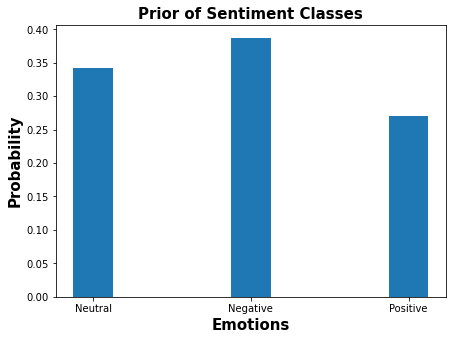

In [8]:
labels  = train_dataframe.label.to_numpy()

values, counts = np.unique(labels, return_counts=True)

fig, ax = plt.subplots(figsize =(7, 5))
plt.bar(values, counts / len(labels), width=0.25)
plt.xlabel('Emotions', fontweight ='bold', fontsize = 15)
plt.ylabel('Probability', fontweight ='bold', fontsize = 15)
plt.xticks([r for r in range(3)],['Neutral','Negative','Positive'])
plt.title('Prior of Sentiment Classes', fontweight ='bold', fontsize = 15)
plt.show()

# Analysis of the Results

According to the prior distribution of the classes, it can be seen that the training dataset is not balanced and the number of data in the Negative class is more than the other two classes.

This causes the network that will be designed in the future to be slightly biased towards the Negative class.

# Part (B) - Histogram, Mean, and Variance of Sentence Length

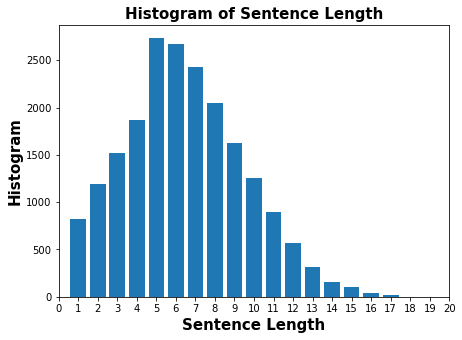

In [9]:
word_count = train_dataframe['text'].str.split().str.len()
word_count = word_count.to_numpy()
values, counts = np.unique(word_count, return_counts=True)


fig, ax = plt.subplots(figsize =(7, 5))
plt.bar(values, counts)
plt.xlabel('Sentence Length', fontweight ='bold', fontsize = 15)
plt.xlim((1,20))
plt.ylabel('Histogram', fontweight ='bold', fontsize = 15)
plt.xticks([r for r in range(21)])
plt.title('Histogram of Sentence Length', fontweight ='bold', fontsize = 15)
plt.show()

In [10]:
print(f'Mean of Sentence Length: {np.mean(word_count):>0.2f}')
print(f'Variance of Sentence Length: {np.var(word_count):>0.2f}')

Mean of Sentence Length: 6.46
Variance of Sentence Length: 9.25


# Part (C) - Histogram, Mean, and Variance of Number of Images per Conversation

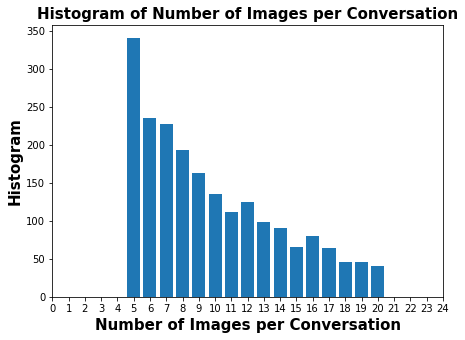

In [11]:
dialogues  = train_dataframe.dialogue.to_numpy()
values, counts = np.unique(dialogues, return_counts=True)
values, counts = np.unique(counts, return_counts=True)


fig, ax = plt.subplots(figsize =(7, 5))
plt.bar(values, counts)
plt.xlabel('Number of Images per Conversation', fontweight ='bold', fontsize = 15)
plt.xlim((1,20))
plt.ylabel('Histogram', fontweight ='bold', fontsize = 15)
plt.xticks([r for r in range(25)])
plt.title('Histogram of Number of Images per Conversation', fontweight ='bold', fontsize = 15)
plt.show()

In [12]:
values, counts = np.unique(dialogues, return_counts=True)

print(f'Mean of Number of Images per Conversation: {np.mean(counts):>0.2f}')
print(f'Variance of Number of Images per Conversation: {np.var(counts):>0.2f}')

Mean of Number of Images per Conversation: 9.80
Variance of Number of Images per Conversation: 17.70


# Part (D) - Histogram, Mean, and Variance of Number of Faces in each Image

Number of Faces in this Photo: 2


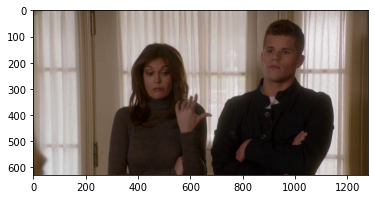

In [13]:
def face_number(img):
    rgb = img.permute(1, 2, 0).numpy()
    boxes = face_recognition.face_locations(rgb, model='hog')
    return len(boxes)

img = train_dataset[8000]['image']
num = face_number(img)


plt.imshow(img.permute(1, 2, 0))
print(f'Number of Faces in this Photo: {num}')

In [14]:
Nsamples = 1000

face_count = np.zeros(Nsamples)

for idx in range(Nsamples):
    sample = train_dataset[idx]
    image = sample['image']
    face_count[idx] = face_number(image)
    
print(f"Due to the time-consuming face recognition process, Histogram is drawn \
for {Nsamples} images from the dataset")

Due to the time-consuming face recognition process, Histogram is drawn for 1000 images from the dataset


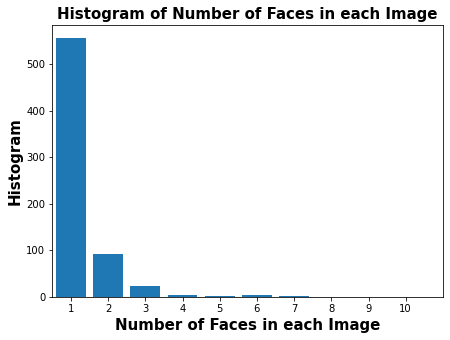

In [15]:
values, counts = np.unique(face_count, return_counts=True)


fig, ax = plt.subplots(figsize =(7, 5))
plt.bar(values, counts)
plt.xlabel('Number of Faces in each Image', fontweight ='bold', fontsize = 15)
plt.xlim((0.5,11))
plt.ylabel('Histogram', fontweight ='bold', fontsize = 15)
plt.xticks([r for r in range(1, 11)])
plt.title('Histogram of Number of Faces in each Image', fontweight ='bold', fontsize = 15)
plt.show()

In [16]:
print(f'Mean of Number of Faces in each Image: {np.mean(face_count):>0.2f}')
print(f'Variance of Number of Faces in each Image: {np.var(face_count):>0.2f}')

Mean of Number of Faces in each Image: 0.86
Variance of Number of Faces in each Image: 0.67


# Part (E) - Correlation of Sentence Length with Emotions

In [17]:
labels  = train_dataframe.label.to_numpy()

word_count = train_dataframe['text'].str.split().str.len()
word_count = word_count.to_numpy()

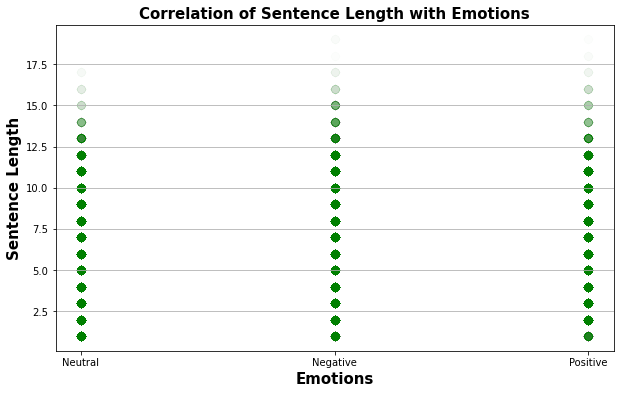

In [18]:
fig, ax = plt.subplots(figsize =(10, 6))
plt.scatter(labels, word_count, alpha=.01, s=70, c='green')
plt.xlabel('Emotions', fontweight ='bold', fontsize = 15)
plt.ylabel('Sentence Length', fontweight ='bold', fontsize = 15)
plt.xticks([r for r in range(3)],['Neutral','Negative','Positive'])
plt.title('Correlation of Sentence Length with Emotions', fontweight ='bold', fontsize = 15)
plt.grid(axis = 'y')
plt.show()

# Analysis of the Results

According to the above graph, it can be seen that:


*   Long sentences are more correlated with negative feeling 

*   Sentences with medium length are more correlated with neutral feeling

*   Sentences with short length are more correlated with positive feeling

# Part (F) - Histogram of Temporal Patterns of Emotion Change in a Conversation

Length of the longest pattern is : 16 .
Lenght of the shortest pattern is : 1 .
The number of all unique patterns of emotions is : 681
The most repeated pattern is : Neut-Neg-Neut and number of repeatition is : 61 .
Because the number of unique patterns is too high, we just show 100 most repeated patterns(descending).


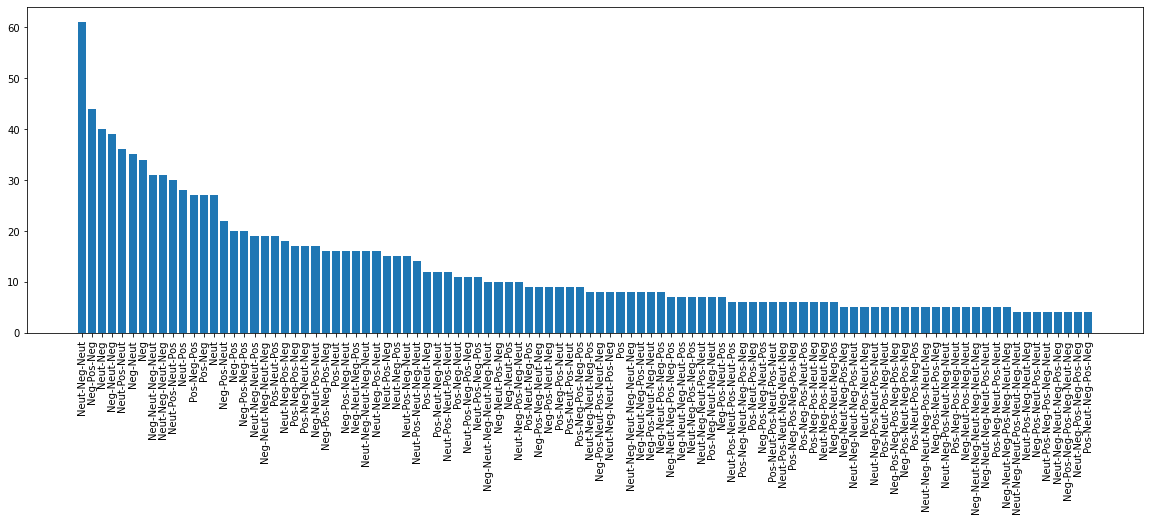

In [19]:
N_dialogue = train_dataframe.dialogue.to_numpy().max()
dialogue_series = []
dialogue_patterns = []
for i in range(N_dialogue + 1):
    dialogue_index = train_dataframe.indexes[i]
    dialogue_index = ast.literal_eval(dialogue_index)
    train_dataframe.label[dialogue_index].to_numpy()  
    dialogue_series.append(train_dataframe.label[dialogue_index].to_numpy())

for serie in dialogue_series:
    pattern = ''
    for idx in range(len(serie)):
        if len(pattern) == 0 or pattern[-1] != str(serie[idx]):
            pattern = pattern + str(serie[idx])
    dialogue_patterns.append(pattern)

print(f'Length of the longest pattern is : {len(max(dialogue_patterns, key=len))} .')
print(f'Lenght of the shortest pattern is : {len(min(dialogue_patterns, key=len))} .')
unique_patterns = (list(set(dialogue_patterns)))
print(f'The number of all unique patterns of emotions is : {len(unique_patterns)}')
patterns_repeat = [dialogue_patterns.count(pattern) for pattern in unique_patterns]
unique_emotions = [p.replace('0','Neut-').replace('1','Neg-').replace('2','Pos-')[:-1] for p in unique_patterns]
print(f'The most repeated pattern is : {unique_emotions[patterns_repeat.index(max(patterns_repeat))]} and number of repeatition is : {max(patterns_repeat)} .')
emotions_dict = dict(zip(unique_emotions, patterns_repeat))
emotions_dict = dict(sorted(emotions_dict.items(), key = lambda x: x[1], reverse = True))

print('Because the number of unique patterns is too high, we just show 100 most repeated patterns(descending).')
fig, ax = plt.subplots(figsize =(20, 6))
plt.bar(list(emotions_dict.keys())[:100], list(emotions_dict.values())[:100])
plt.xticks(rotation = 90)
plt.show()

# Part (G) - The Number of Theoretically Possible Emotion Patterns

In [20]:
dialogues  = train_dataframe.dialogue.to_numpy()
values, counts = np.unique(dialogues, return_counts=True)

print(f'Average Conversation Length: {np.mean(counts):>0.2f}')
print(f'Standard Deviation of Conversation Length: {np.std(counts):>0.2f}')

Average Conversation Length: 9.80
Standard Deviation of Conversation Length: 4.21


# Analysis of the Results

Assuming that all conversations consist of 10 sentences, according to the permutation of three positive, negative and neutral emotions, the number of possible emotion patterns is theoretically equal to:

$3 × 2 × 2 × … × 2 = 3 × 2^9 = 1536$

The above result differs from the number of histogram classes in the last section for two reasons:



*   First, due to the relatively large standard deviation equal to 4.21, considering the length of conversations with the average will cause a calculation error.
*   Secondly, all the patterns considered in the calculations do not necessarily occur in practice. For example, the **negative, positive, negative, positive** pattern may occur with a very small probability.


